In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
pd.set_option("display.float_format", lambda x: format(x, "0,.4f"))

In [5]:
sns.set_palette("colorblind")
%config InlineBackend.figure_format = "retina"

In [6]:
agents = ["LRKF", "FLoRES", "FLoRESLite", "adamw", "LoFi", "muon"]
# agents = ["LRKF", "FLoRES", "adamw", "LoFi"]

In [7]:
def plot_rewards(rewards, hatch, color, **kwargs):
    rewards = pd.DataFrame(rewards)
    
    median = rewards.cumsum().mean(axis=1)
    # lbound = rewards.cumsum().quantile(0.25, axis=1)
    # ubound = rewards.cumsum().quantile(0.75, axis=1)
    
    median.plot(color=color, **kwargs)
    # plt.fill_between(median.index, lbound, ubound, alpha=0.3, color=color)

In [8]:
def plot_rewards(rewards, hatch, color, **kwargs):
    rewards = pd.DataFrame(rewards)

    stat = rewards.expanding(min_periods=1000).mean()
    median = stat.mean(axis=1)
    # lbound = stat.quantile(0.25, axis=1)
    # ubound = stat.quantile(0.75, axis=1)
    
    median.plot(color=color, **kwargs)
    # plt.fill_between(median.index, lbound, ubound, alpha=0.2, color=color, hatch=hatch)

In [9]:
agents = ["LRKF", "FLoRES", "FLoRESLite", "adamw", "LoFi", "muon"]

In [10]:
date1 = "20250421"
date2 = "20250422"

In [11]:
agent_map = {agent: agent for agent in agents}
agent_map["FLoRES"] = "HiLoFi"
agent_map["FLoRESLite"] = "LoLoFi"

CPU times: user 1.02 s, sys: 56.5 ms, total: 1.08 s
Wall time: 1.1 s


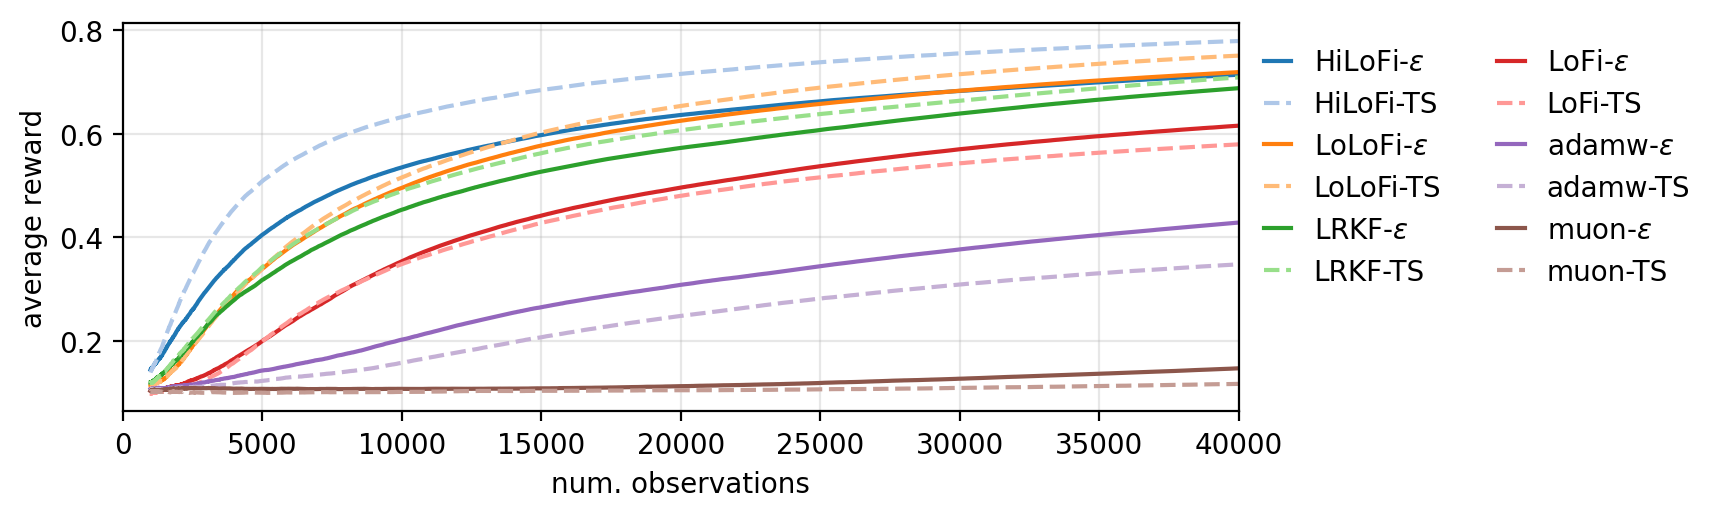

In [12]:
%%time
fig, ax = plt.subplots(figsize=(7.2, 4.2 * 0.6))

res_methods = {}

colors = sns.color_palette("tab20")
hatches = ["x", "o"]
for i, agent in enumerate(sorted(agents)):
    date = date2 if (agent == "FLoRES") or (agent == "FLoRESLite") else date1
    agent_path_eps = f"./output/{agent}_eps_5_{date}.pkl"
    agent_path_ts = f"./output/{agent}_ts_{date}.pkl"
    
    # agent_path_eps = f"./output/{agent}_eps_5.pkl"
    # agent_path_ts = f"./output/{agent}_ts.pkl"

    agent = agent_map[agent]
    res = pd.read_pickle(agent_path_eps)
    plot_rewards(
        res["rewards"].T, label=rf"{agent}-$\epsilon$",
        color=colors[2 * i], hatch=hatches[i % 2]
    )

    res_methods[f"{agent}-es"] = {
        "reward": res["rewards"].sum(axis=1).mean(),
        "time": res["time"],
    }

    res = pd.read_pickle(agent_path_ts)
    plot_rewards(
        res["rewards"].T, label=f"{agent}-TS", linestyle="--",
        color=colors[2 * i  + 1], hatch=hatches[(2 * i  + 1) % 2]
    )

    res_methods[f"{agent}-ts"] = {
        "reward": res["rewards"].sum(axis=1).mean(),
        "time": res["time"],
    }
    
plt.legend(ncol=2, handlelength=1, bbox_to_anchor=(1,1), frameon=False)
plt.xlabel("num. observations")
plt.ylabel("average reward")
plt.grid(alpha=0.3)
plt.xlim(0, 40_000)
plt.savefig("../figures/mnist-bandit-reward.png", dpi=300, bbox_inches="tight")

In [13]:
def replace_name(x):
    x = x.replace("ts", "TS")
    x = x.replace("es", r"$\epsilon$")
    return x

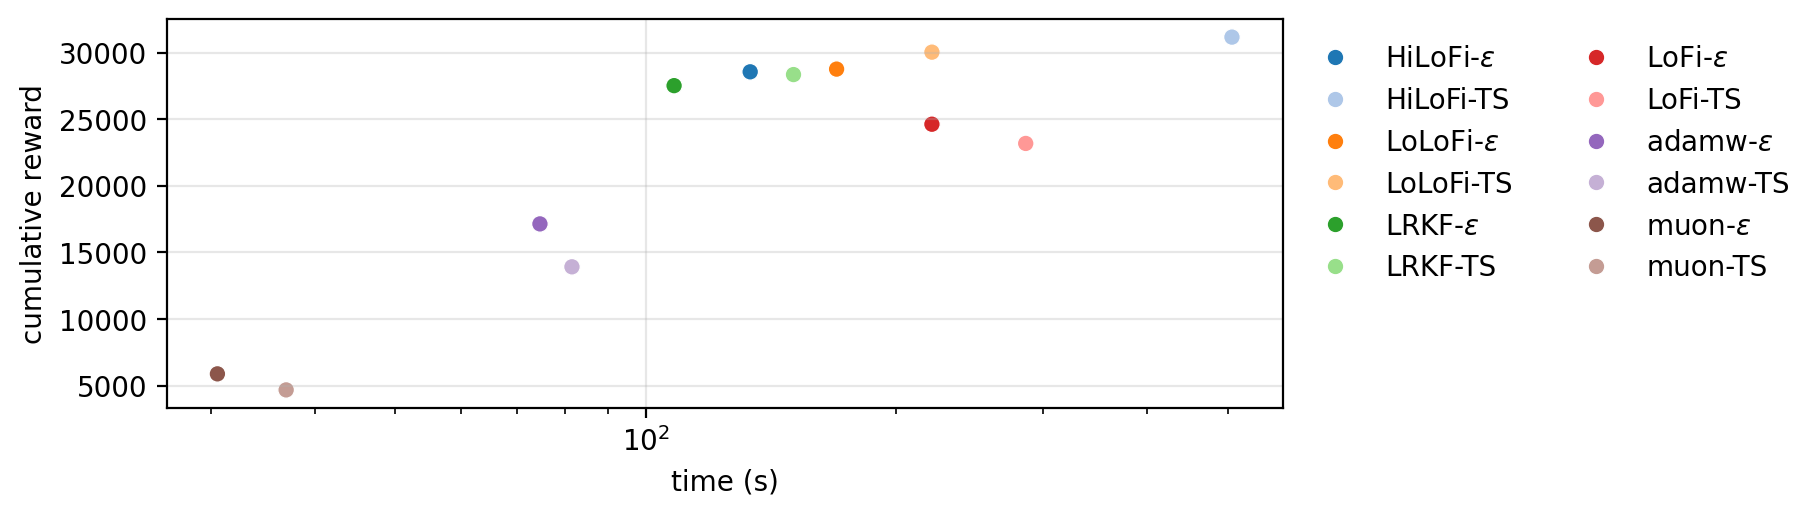

In [16]:
fig, ax = plt.subplots(figsize=(7.2, 4.2 * 0.6))

res_summary = pd.DataFrame.from_dict(res_methods, orient="index")
names = [replace_name(x) for x in res_summary.index]

sns.scatterplot(
    x="time", y="reward", hue="index", data=res_summary.reset_index().assign(index=names),
    palette="tab20"
)
# plt.yscale("log")
plt.legend(ncol=2, bbox_to_anchor=(1,1), frameon=False)
plt.xscale("log")
plt.xlabel("time (s)")
plt.ylabel("cumulative reward")
plt.grid(alpha=0.3)
plt.savefig("../figures/mnist-bandit-time-reward.png", dpi=300, bbox_inches="tight")